In [ ]:
import math

from impl.classical_ec.elliptic_curves import point_doubling, get_curve
from impl.shors.Shors_ECDLP import shors_ecdlp

shots = 2000

In [ ]:
# Choose an elliptic curve e.g:
elliptic_curve = get_curve(a=0, b=5, modulus=7)
p = elliptic_curve.modulus
n = math.ceil(math.log2(p))
P = (6, 5)  # P
Q = (3, 2)  # Q = [m]*P
r = -1  # Could theoretically be calculated by the SEA algorithm in polynomial time!


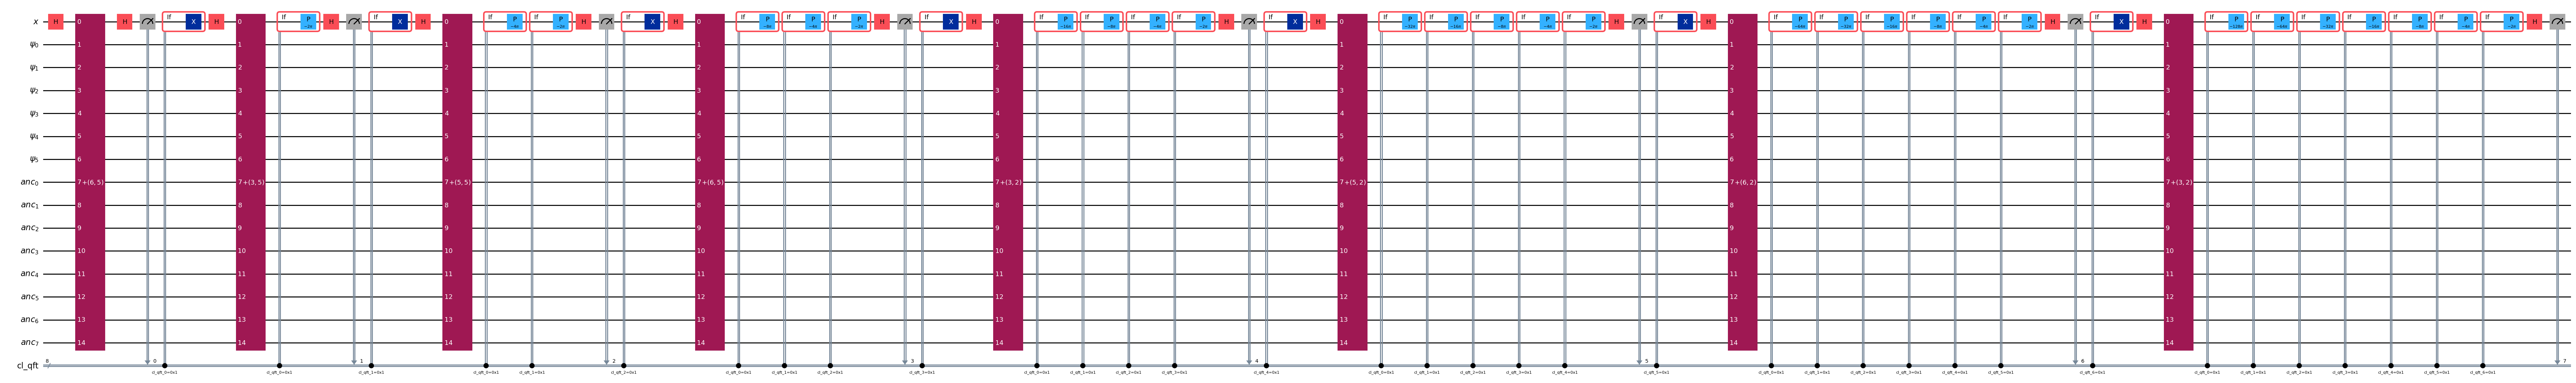

In [3]:
from api.Metrics import gate_count_metric
from api.CircuitChooser import CircuitChooser

points = []
# Classically generate the points [P, 2P, 4P, ... , 2^n*P]
for i in range(0, n + 1):
    points.append(point_doubling(elliptic_curve, P, 2 ** i))
# And then generate the points [Q, 2Q, ... 2^n*Q]
for j in range(0, n + 1):
    points.append(point_doubling(elliptic_curve, Q, 2 ** j))

CircuitChooser()._metric = gate_count_metric
circuit = shors_ecdlp(points, p)

circuit.draw(output='mpl', fold=-1)

In [4]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator

simulator = AerSimulator()
# Allow circuit to run on our backend.

circuit = generate_preset_pass_manager(backend=simulator, optimization_level=3).run(circuit)
print(circuit.count_ops())

OrderedDict({'cx': 23673, 'u': 16688, 'ccx': 15594, 'x': 3410, 'cu': 2488, 'mcx': 387, 'mcphase': 240, 'p': 200, 'if_else': 35, 'h': 16, 'measure': 8})


In [5]:
job = simulator.run(circuit, shots=shots)

counts = job.result().get_counts()

print(counts)

{'01011110': 2, '11110000': 3, '11000011': 1, '10101111': 1, '11110011': 4, '10011110': 4, '10001100': 3, '11100100': 5, '01010100': 4, '10000100': 10, '01111011': 14, '01111000': 2, '01100010': 2, '00101110': 5, '11101010': 5, '11000100': 10, '01000111': 7, '10001011': 3, '00011100': 7, '10110000': 11, '11000010': 2, '01111111': 11, '11010111': 4, '11101001': 8, '01110001': 1, '01100101': 7, '11110100': 8, '00010000': 6, '01101000': 5, '00000101': 8, '10001111': 8, '01101111': 9, '00101001': 10, '11010000': 5, '11110101': 3, '11100010': 7, '11011110': 6, '01011011': 7, '11011010': 8, '11000101': 7, '00011001': 12, '01100110': 10, '01010111': 2, '10110111': 18, '01011111': 12, '10111011': 8, '10011011': 4, '10011100': 5, '01010011': 4, '11111101': 10, '11001111': 6, '00110110': 11, '01100001': 4, '00001010': 7, '00100110': 11, '01111110': 7, '10111010': 8, '10100010': 6, '00101010': 2, '11001011': 5, '10000001': 6, '10001010': 10, '10000101': 9, '10101110': 5, '11101011': 9, '11101100'

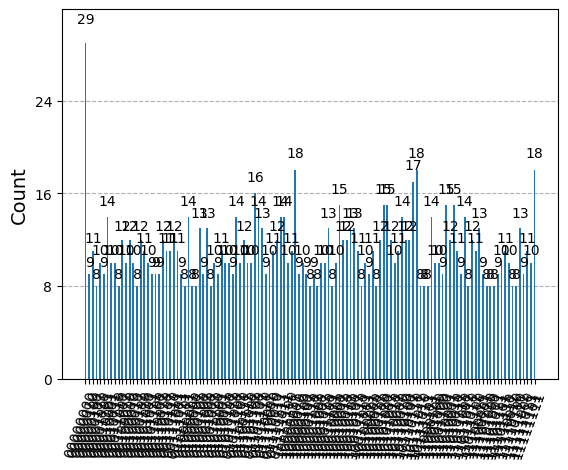

In [6]:
from qiskit.visualization import plot_histogram

# Hold back so the plots aren't too messy.
filtered_counts = dict(filter(lambda item: not (isinstance(item[1], int) and item[1] < 8), counts.items()))
plot_histogram(filtered_counts)
# plot_distribution(counts)

In [7]:
# Use Quaspy for post processing
from quaspy.math.groups import PointOnShortWeierstrassCurveOverPrimeField, ShortWeierstrassCurveOverPrimeField
from quaspy.orderfinding.general.postprocessing.ekera import solve_j_for_r

if r == -1:
    r = 2 * p + 2  # Backup frequency if all else fails, should be more or else similar to Hasse's bound (probably wrong)
    for (j, _) in counts.items():
        r_cand = solve_j_for_r(j, n + 1, n + 1, PointOnShortWeierstrassCurveOverPrimeField(P[0], P[1],
                                                                                           E=ShortWeierstrassCurveOverPrimeField(
                                                                                               elliptic_curve.a,
                                                                                               elliptic_curve.b,
                                                                                               elliptic_curve.modulus)))
        r = min(r, r_cand)

print("Period: " + str(r))

Period: 7


In [8]:
result_list = list()
for result in counts.keys():
    # split result measurements
    m_stage1 = int(result[:n // 2], 2)
    m_stage2 = int(result[n // 2:], 2)

    result_list.append((m_stage1, m_stage2, counts[result]))
print(len(result_list))
print(result_list)

256
[(0, 94, 2), (1, 112, 3), (1, 67, 1), (1, 47, 1), (1, 115, 4), (1, 30, 4), (1, 12, 3), (1, 100, 5), (0, 84, 4), (1, 4, 10), (0, 123, 14), (0, 120, 2), (0, 98, 2), (0, 46, 5), (1, 106, 5), (1, 68, 10), (0, 71, 7), (1, 11, 3), (0, 28, 7), (1, 48, 11), (1, 66, 2), (0, 127, 11), (1, 87, 4), (1, 105, 8), (0, 113, 1), (0, 101, 7), (1, 116, 8), (0, 16, 6), (0, 104, 5), (0, 5, 8), (1, 15, 8), (0, 111, 9), (0, 41, 10), (1, 80, 5), (1, 117, 3), (1, 98, 7), (1, 94, 6), (0, 91, 7), (1, 90, 8), (1, 69, 7), (0, 25, 12), (0, 102, 10), (0, 87, 2), (1, 55, 18), (0, 95, 12), (1, 59, 8), (1, 27, 4), (1, 28, 5), (0, 83, 4), (1, 125, 10), (1, 79, 6), (0, 54, 11), (0, 97, 4), (0, 10, 7), (0, 38, 11), (0, 126, 7), (1, 58, 8), (1, 34, 6), (0, 42, 2), (1, 75, 5), (1, 1, 6), (1, 10, 10), (1, 5, 9), (1, 46, 5), (1, 107, 9), (1, 108, 6), (0, 115, 12), (0, 75, 6), (1, 109, 10), (0, 34, 10), (0, 67, 3), (0, 1, 7), (1, 63, 14), (1, 104, 8), (0, 35, 8), (1, 95, 13), (1, 83, 11), (1, 64, 5), (1, 44, 4), (0, 24, 5)

In [9]:
from quaspy.logarithmfinding.general.postprocessing import solve_j_k_for_d_given_r

num_correct = 0
num_wrong = 0
m = -1

curve = ShortWeierstrassCurveOverPrimeField(elliptic_curve.a, elliptic_curve.b, elliptic_curve.modulus)

for (j, k, freq) in result_list:
    m_cand = solve_j_k_for_d_given_r(j, k, n + 1, 0, n + 1,
                                     PointOnShortWeierstrassCurveOverPrimeField(P[0], P[1], E=curve),
                                     PointOnShortWeierstrassCurveOverPrimeField(Q[0], Q[1], E=curve), r)

    if (point_doubling(elliptic_curve, P, m_cand)) == Q:
        if m != -1:
            m = min(m, int(m_cand))
        else:
            m = int(m_cand)
        num_correct += freq
    else:
        num_wrong += freq

print(f"Solution: {m}, with {num_correct / shots * 100}% of post-processed states leading to the solution.")
print(point_doubling(elliptic_curve, P, m))

Solution: 5, with 100.0% of post-processed states leading to the solution.
(3, 2)
